In [0]:
from pyspark.sql import Row
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, mean as _mean, stddev as _stddev, log, log10
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit
from pyspark.sql.types import IntegerType
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf, expr, concat, col, count, when, isnan

spark = SparkSession(sc)
sqlc=SQLContext(sc)

In [0]:
train_features = sqlc.read.csv('/FileStore/tables/train_features.csv', header = True,inferSchema=True)
train_targets_scored = sqlc.read.csv('/FileStore/tables/train_targets_scored.csv', header = True,inferSchema=True)

In [0]:
# compute number of 1 and percentage of 1 of all targets
value_1 = []
percent_1 = []
l_target = train_targets_scored.schema.names[1:]

for i in range (1, len(l_target)):
  v_1 = train_targets_scored.select(l_target[i]).where(train_targets_scored[l_target[i]] == '1').count()
  v_0 = train_targets_scored.select(l_target[i]).where(train_targets_scored[l_target[i]] == '0').count()
  value_1.append(v_1)
  percent_1.append(v_1 / (v_1 + v_0)*100)

# select the top 5 and bottom 5 targets
DF = sqlContext.createDataFrame(zip(l_target, value_1, percent_1), schema=['targets', '# of 1', '% of 1'])
DF = DF.orderBy(col('% of 1').desc())
df_top5 = DF.limit(5)
df_last5 =  DF.orderBy(col('% of 1')).limit(5)
dfs = df_top5.union(df_last5)

Out[6]:

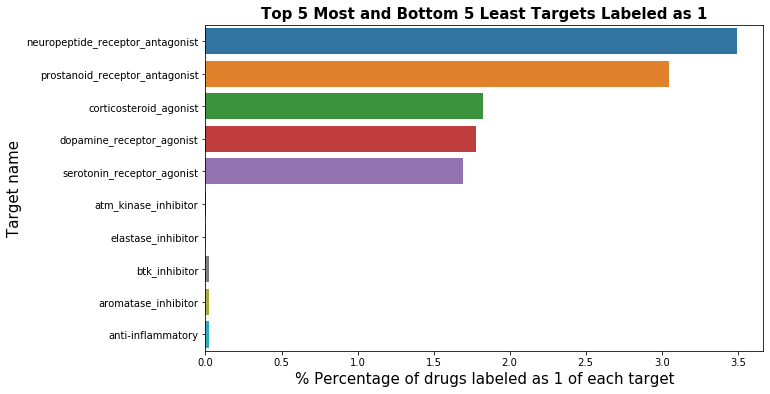

Text(0.5, 1.0, 'Top 5 Most and Bottom 5 Least Targets Labeled as 1')

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_target =  dfs.select("*").toPandas()
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=df_target['% of 1'], y=df_target.targets)
ax.set_ylabel("Target name", fontsize=15)
ax.set_xlabel("% Percentage of drugs labeled as 1 of each target", fontsize=15)
ax.set_title('Top 5 Most and Bottom 5 Least Targets Labeled as 1', fontdict= { 'fontsize': 15, 'fontweight':'bold'})

In [0]:
# compute number of targets in each target types
target_type = ['inhibitor', 'antagonist', 'agonist', 'activator', 'agent', 'stimulant', 'blocker', 'diuretic', 'donor', 'steroid', 'laxative', 'medium', 'anti', 'scavenger', 'local', 'secretagogue', 'vitamin', 'analgesic', 'immu']
type_len = []
for i in target_type:
  typ = DF.filter(DF.targets.contains(i))
  type_len.append(typ.count())    
df_type = sqlContext.createDataFrame(zip(target_type, type_len), schema=['target_type', 'sum'])
df_type = df_type.sort(col('sum').desc())
df_type.show()

Out[28]:

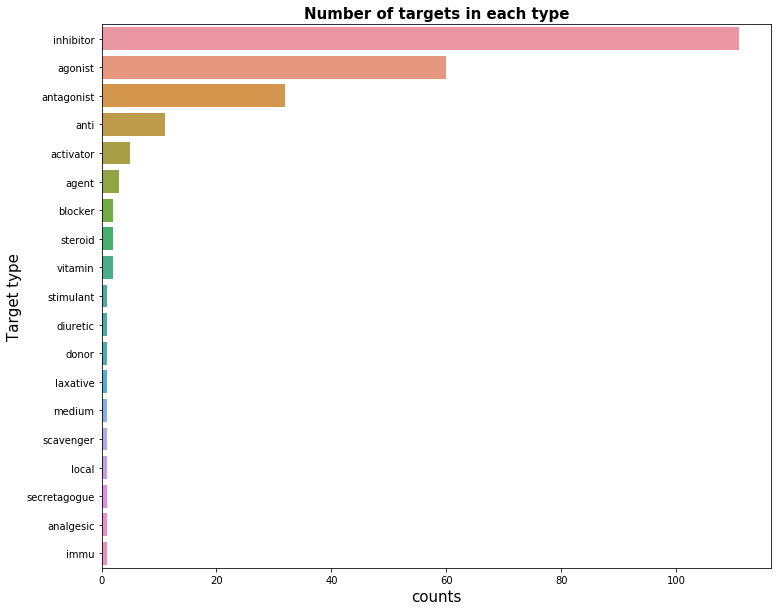

Text(0.5, 1.0, 'Number of targets in each type')

In [0]:
df_typ =  df_type.select("*").toPandas()
df_typ = df_typ.astype({"sum": int, "target_type": str})
f, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=df_typ['sum'], y=df_typ.target_type)
ax.set_ylabel("Target type", fontsize=15)
ax.set_xlabel("counts", fontsize=15)
ax.set_title('Number of targets in each type', fontdict= { 'fontsize': 15, 'fontweight':'bold'})

Out[29]:

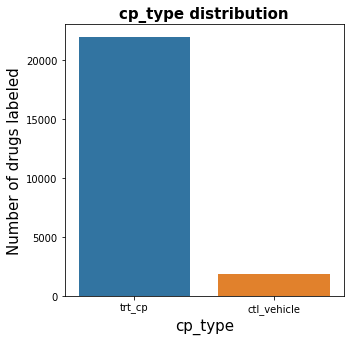

Text(0.5, 1.0, 'cp_type distribution')

In [0]:
# distribution of cp_type
trt_cp = train_features.select("cp_type").where(train_features.cp_type == 'trt_cp').count()
ctl_vehicle = train_features.select("cp_type").where(train_features.cp_type == 'ctl_vehicle').count()
f, ax = plt.subplots(figsize=(5, 5))
sns.barplot(['trt_cp', 'ctl_vehicle'], [trt_cp, ctl_vehicle])
ax.set_ylabel('Number of drugs labeled', fontsize=15)
ax.set_xlabel('cp_type', fontsize=15)
ax.set_title("cp_type distribution", fontdict= { 'fontsize': 15, 'fontweight':'bold'})

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# filter cell and gene type features
g_list = [i for i in train_features.schema.names if i.startswith('g-')]
c_list = [i for i in train_features.schema.names if i.startswith('c-')]

# define a function that can compute top and bottom variance features
def corr (feature, set_max, set_min):
  
  ass = VectorAssembler(inputCols=[x for x in train_features.schema.names if x in feature], outputCol="features")
  corr_input = ass.transform(train_features).select("features")
  r_target = Correlation.corr(corr_input, "features").collect()[0][0]
  corrmatrix = r_target.toArray().tolist()
  corr_tar = spark.createDataFrame(corrmatrix,feature)
  pd_df_corr = corr_tar.select("*").toPandas()
  pd_corr = pd_df_corr.abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
  pd_corr = pd_corr[pd_corr['level_0'] != pd_corr['level_1']]
  
  corr_max = pd_corr.level_0.head(set_max).tolist()
  corr_max = list(set(corr_max))
  
  corr_min = pd_corr.level_0.tail(set_min).tolist()
  corr_min = list(set(corr_min))
  
  correlation_train_max = pd_df_corr.loc[:,corr_max].corr()
  mask_max = np.triu(correlation_train_max.corr())
  
  correlation_train_min = pd_df_corr.loc[:,corr_min].corr()
  mask_min = np.triu(correlation_train_min.corr())
  
  return correlation_train_max, correlation_train_min, mask_max, mask_min

Out[38]:

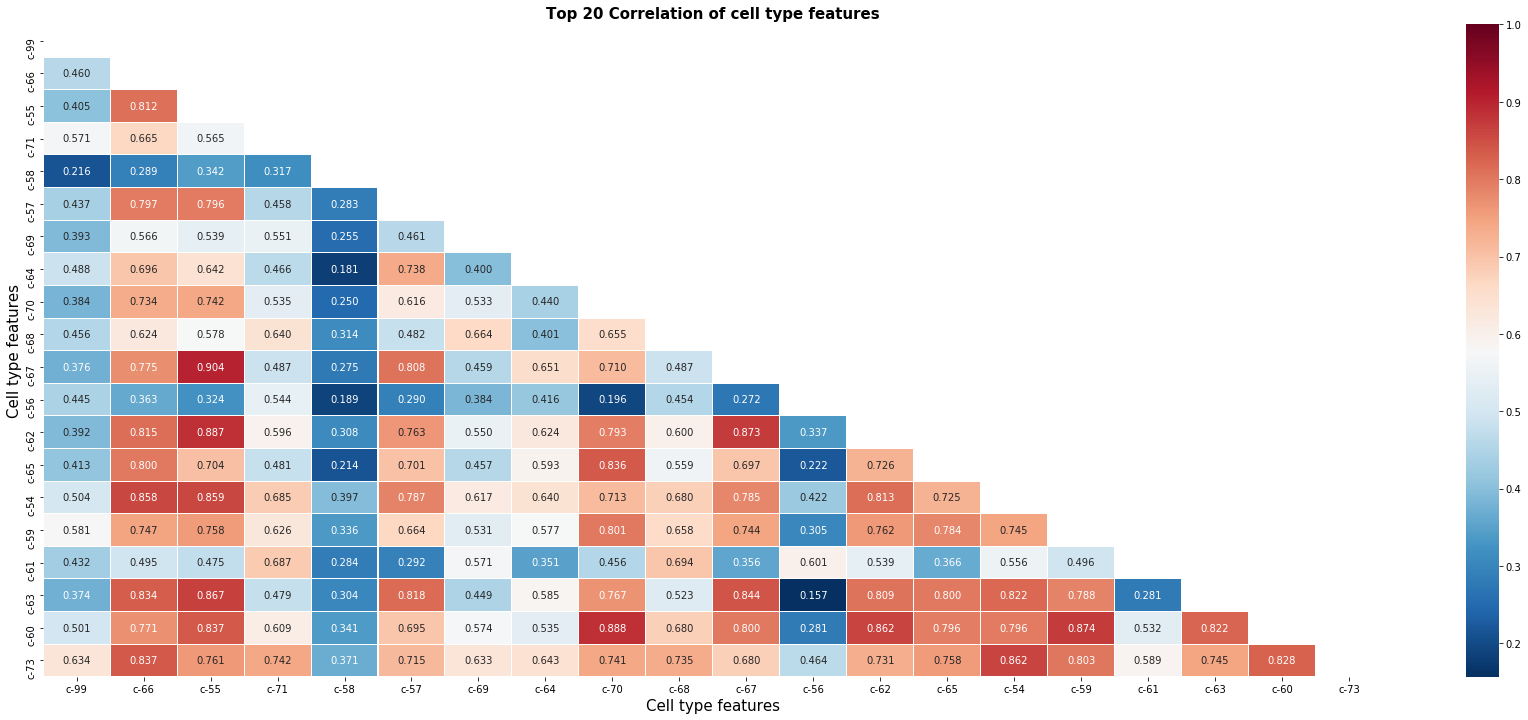

Text(0.5, 1, 'Top 20 Correlation of cell type features')

In [0]:
c_correlation_train_max, c_correlation_train_min, c_mask_max, c_mask_min = corr (c_list, 20, 20)

# top 20 correlation of cell features
f, ax = plt.subplots(figsize=(30, 12))
sns.heatmap(c_correlation_train_max,
            mask=c_mask_max,
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            linewidths=0.01,
            cbar=True)
ax.set_ylabel('Cell type features', fontsize=15)
ax.set_xlabel('Cell type features', fontsize=15)
ax.set_title("Top 20 Correlation of cell type features", fontdict= { 'fontsize': 15, 'fontweight':'bold'})

In [0]:
# # NaiveBayes model
# from pyspark.ml.classification import NaiveBayes
# from pyspark.ml.feature import StringIndexer

# df_train = train_features.join(train_targets_scored.select(l[1]))
# df_train = df_train.drop('cp_type')
# df_train_clean = StringIndexer().setInputCol("cp_dose").setOutputCol("cp_dose_enco").fit(df_train).transform(df_train)
# df_train_clean = StringIndexer().setInputCol("cp_time").setOutputCol("cp_time_enco").fit(df_train).transform(df_train_clean)
# df_train_clean = df_train_clean.drop('cp_dose')
# df_train_clean = df_train_clean.drop('cp_time')
# df_train_clean = df_train_clean.drop('sig_id')
# df_target = train_targets_scored.drop('sig_id')
# train, test = df_train_clean.randomSplit([0.7, 0.3],1234)
# assembler = VectorAssembler(inputCols=[x for x in df_train_clean.schema.names], outputCol="features")
# train_df = (assembler.transform(train).select('5-alpha_reductase_inhibitor', "features"))
# test_df = (assembler.transform(test).select('5-alpha_reductase_inhibitor', "features"))
# nb = NaiveBayes(labelCol='5-alpha_reductase_inhibitor', featuresCol="features",smoothing=1.0, modelType="multinomial")
# model = nb.fit(train_df)
# predictions = model.transform(test_df)
# display(predictions.select("label", "prediction", "probability"))